**Модуль 10. Згорткові нейронні мережі**

---
**Частина 1**

​В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
import copy

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

4422102/4422102 [==============================] - 0s 0us/step


**Перевірка датасету**

In [3]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

**Функція відображення графіків втрат і точності на наборах даних**

In [4]:
def plot_history(history):
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'r', label='Втрати на тренувальному наборі')
    plt.plot(epochs, val_loss, 'b', label='Втрати на тестовому наборі')
    plt.plot(epochs, train_acc, 'g', label='Точність на тренувальному наборі')
    plt.plot(epochs, val_acc, 'y', label='Точність на тестовому наборі')

    plt.title('Втрати та точність на тренувальному та тестовому наборі')
    plt.xlabel('Епоха')
    plt.ylabel('Метрики')
    plt.legend()
    plt.show()

**Функція пошуку оптимальних параметрів**

У якості аргументів:
1. Набори даних для навчання і валідації
2. Параметри для тренування моделі
3. Оптимальні параметри. Спочатку рандомні, які потім змінюються на оптимальні.
4. Послідовність параметрів, що мають перевірятися.
5. Функція, що містить модель для тренування

In [5]:
def find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model_func):
    best_accuracy = 0.0
    best_parameters = {}

    for param in study_sequence:
        print(f"Searching for optimal value for parameter: {param}")
        param_values = parameters[param]
        best_value = optimal_parameters[param]
        for value in param_values:
            optimal_parameters[param] = value
            print(f"Testing value: {value}")
            model, history, (test_loss, test_acc), (train_loss, train_acc) = train_model_func(train_images, train_labels, test_images, test_labels, **optimal_parameters)
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value
            # Результати навчання для параметра
            print(f"Досліджений параметр {param} = {value}")

            plot_history(history)
            print('Parameters', optimal_parameters)
            print('test_loss =', test_loss)
            print('test_acc =', test_acc)
            print('train_loss =', train_loss)
            print('train_acc =', train_acc)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value
        print(f"Optimal value for parameter {param}: {best_value}, test accuracy: {best_accuracy}")
        print()

    print("Optimal parameters:")
    print(best_parameters)
    print(f"Test accuracy: {best_accuracy}")
    return best_parameters, best_accuracy


**Модель для тренування 1**

---

Має шари:
1. **Conv2D** (32 фільтри, розмір ядра 3x3, активація ReLU): для виявлення локальних ознак у вхідних зображеннях. Він має 32 фільтри з розміром ядра 3x3, що скользуть по вхідному зображенню. Активація ReLU застосовується після кожного згорткового перетворення.

2. **MaxPooling2D** (пулінг з розміром пікселя 2x2): для пониження розмірності отриманих ознак шляхом вибору максимального значення з кожної області розміру 2x2.

3. **Conv2D** (64 фільтри, розмір ядра 3x3, активація ReLU): для виявлення більш складних ознак на вищому рівні.

4. **MaxPooling2D** (пулінг з розміром пікселя 2x2): допомагає подолати проблему перенавчання та зменшує кількість параметрів.

5. **Flatten**: перетворює тривимірний вихід попереднього шару в одномірний вектор.

6. **Dense** (повністю з'єднаний шар зі 128 нейронами, активація ReLU): для обробки отриманих ознак.

7. **Dropout**: Цей шар застосовує Dropout з заданим dropout_rate для регуляризації моделі та запобігання перенавчанню.

8. **Dense** (повністю з'єднаний шар з 10 нейронами, активація softmax): використовується для прогнозування ймовірностей належності до кожного класу (один з 10 класів Fashion MNIST).

In [6]:
def train_model(train_images, train_labels, test_images, test_labels, epochs=20, batch_size=32, dropout_rate=0.1,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', hidden_units=64,
                activation='relu', metrics=['accuracy']):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), callbacks=[early_stopping])

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, (test_loss, test_acc), (train_loss, train_acc)


**Перевірка моделі 1 на параметрах за замовчанням**

In [8]:
model_1_testing = train_model(train_images, train_labels, test_images, test_labels,
            epochs=20,
            batch_size=32,
            dropout_rate=0.1,
            loss_function='sparse_categorical_crossentropy',
            optimizer='adam',
            hidden_units=64,
            activation='relu',
            metrics=['accuracy'])

Epoch 1/20
1875/1875 [==============================] - 14s 4ms/step - loss: 0.4921 - accuracy: 0.8204 - val_loss: 0.3622 - val_accuracy: 0.8715
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3270 - accuracy: 0.8805 - val_loss: 0.3119 - val_accuracy: 0.8879
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2835 - accuracy: 0.8953 - val_loss: 0.3030 - val_accuracy: 0.8904
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2505 - accuracy: 0.9072 - val_loss: 0.2633 - val_accuracy: 0.9025
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2269 - accuracy: 0.9151 - val_loss: 0.2842 - val_accuracy: 0.8963
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2067 - accuracy: 0.9232 - val_loss: 0.2702 - val_accuracy: 0.9012
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1913 - accuracy: 0.9280 - val_loss: 0.2545 - val_accuracy

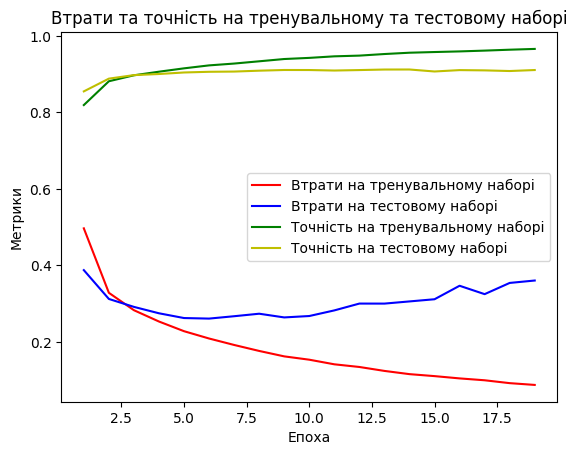

In [11]:
plot_history(model_1_testing[1])

**Висновок №1.**

---

**З графіків тренування моделі за замовчуванням можна зробити
висновок, що:**
1. модель схильна до перенавчання
2. Точність  **97.1% на тренувальних** даних та близько **91.4% на тестових** даних
---


**Параметри, для навчання моделі 1**


Послідовність навчання відповідно до **study_sequence**

**Оптимізатор** (**optimizer**) : Оскільки цей параметр впливає на швидкість збіжності та точність моделі, його рекомендується перевіряти першим. Можна спочатку спробувати один з найефективніших оптимізаторів, таких як Adam або RMSprop, а потім зробити порівняння з SGD.

**Функція втрат (loss function)**: 'sparse_categorical_crossentropy'

**Функція активації (activation)**. Зазвичай рекомендується спочатку спробувати ReLU, а потім, якщо це не дало задовільних результатів, спробуйте інші функції, такі як tanh або sigmoid.

**Кількість прихованих нейронів (hidden units)**: спочатку використовувати меншу кількість нейронів (наприклад, 128), а потім поступово збільшувати.

**Коефіцієнт випадкового вимикання (dropout rate)**: Найбільш важливо визначити оптимальний dropout rate після встановлення оптимальних значень для інших параметрів, оскільки це може вплинути на регуляризацію моделі.

**Кількість епох (epochs) та розмір пакета (batch size)**: Після вибору оптимальних параметрів моделі, ви можете провести додаткові експерименти для визначення найкращих значень для кількості епох і розміру пакета.

In [7]:
study_sequence = [
                  'optimizer',
                  'activation',
                  'hidden_units',
                  'dropout_rate',
                  'batch_size',
                  'loss_function']
#                  'metrics',
#                  'epochs']

optimal_parameters = {
    'epochs': 20,
    'batch_size': 32,
    'dropout_rate': 0.1,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'adam',
    'hidden_units': 64,
    'activation': 'relu',
    'metrics': ['accuracy']
    }

# Списки параметрів, що мають бути досліджені під час навчання

parameters = {
    'epochs': [10, 20, 30],
    'batch_size': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'loss_function': ['sparse_categorical_crossentropy'],
    'optimizer': ['adam', 'rmsprop'],
    'hidden_units': [128, 256, 512],
    'activation': ['relu', 'tanh'],
    'metrics': ['accuracy']
    }


Searching for optimal value for parameter: optimizer
Testing value: adam
Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4925 - accuracy: 0.8209 - val_loss: 0.3592 - val_accuracy: 0.8723
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3283 - accuracy: 0.8800 - val_loss: 0.3109 - val_accuracy: 0.8880
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2812 - accuracy: 0.8958 - val_loss: 0.2760 - val_accuracy: 0.8971
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2496 - accuracy: 0.9078 - val_loss: 0.2773 - val_accuracy: 0.8999
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2259 - accuracy: 0.9165 - val_loss: 0.2500 - val_accuracy: 0.9090
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2054 - accuracy: 0.9231 - val_loss: 0.2510 - val_accuracy: 0.9092
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/

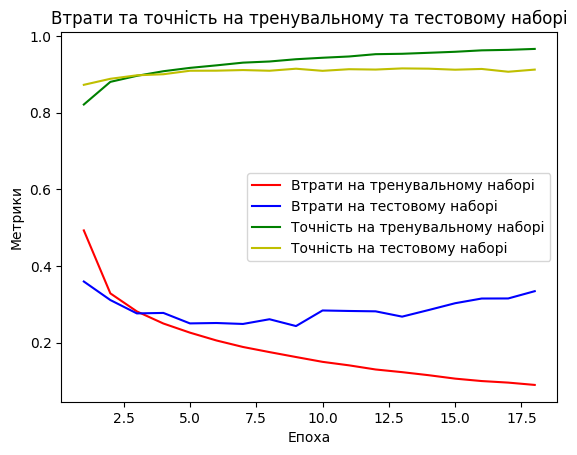

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 64, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.26760101318359375
test_acc = 0.9150999784469604
train_loss = 0.08154550939798355
train_acc = 0.972266674041748
Testing value: rmsprop
Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.5093 - accuracy: 0.8142 - val_loss: 0.3510 - val_accuracy: 0.8726
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3259 - accuracy: 0.8823 - val_loss: 0.3111 - val_accuracy: 0.8878
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2799 - accuracy: 0.9003 - val_loss: 0.3005 - val_accuracy: 0.8943
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2546 - accuracy: 0.9079 - val_loss: 0.2960 - val_accuracy: 0.8949
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - l

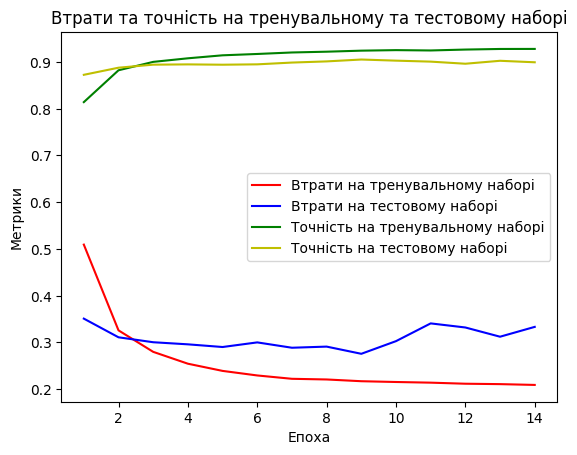

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'hidden_units': 64, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.27576446533203125
test_acc = 0.9053000211715698
train_loss = 0.18444979190826416
train_acc = 0.9381833076477051
Optimal value for parameter optimizer: adam, test accuracy: 0.9150999784469604

Searching for optimal value for parameter: activation
Testing value: relu
Epoch 1/20
1875/1875 [==============================] - 10s 4ms/step - loss: 0.5069 - accuracy: 0.8160 - val_loss: 0.3575 - val_accuracy: 0.8711
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3312 - accuracy: 0.8792 - val_loss: 0.3262 - val_accuracy: 0.8805
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2862 - accuracy: 0.8952 - val_loss: 0.2809 - val_accuracy: 0.8995
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2

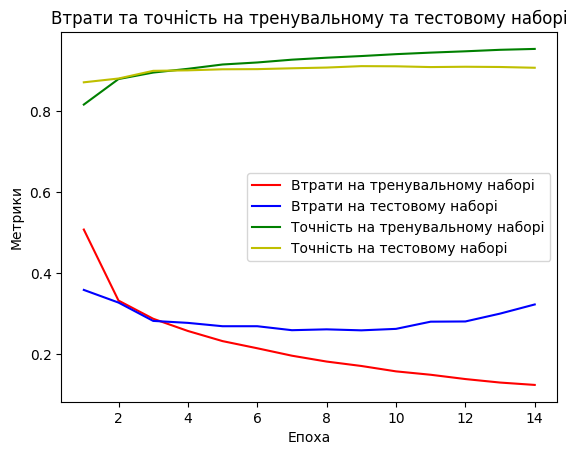

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 64, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.2575415372848511
test_acc = 0.9110999703407288
train_loss = 0.1329868733882904
train_acc = 0.951533317565918
Testing value: tanh
Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4899 - accuracy: 0.8213 - val_loss: 0.3726 - val_accuracy: 0.8639
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3272 - accuracy: 0.8791 - val_loss: 0.3232 - val_accuracy: 0.8810
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2798 - accuracy: 0.8970 - val_loss: 0.2967 - val_accuracy: 0.8913
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2520 - accuracy: 0.9076 - val_loss: 0.2701 - val_accuracy: 0.8982
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 

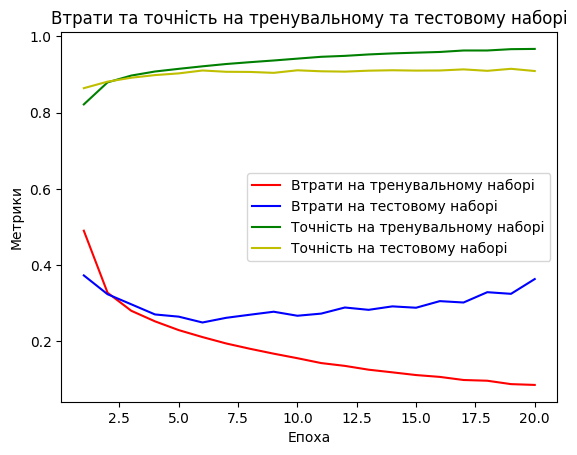

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 64, 'activation': 'tanh', 'metrics': ['accuracy']}
test_loss = 0.3630136549472809
test_acc = 0.9089000225067139
train_loss = 0.062365852296352386
train_acc = 0.9757999777793884
Optimal value for parameter activation: relu, test accuracy: 0.9150999784469604

Searching for optimal value for parameter: hidden_units
Testing value: 128
Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4690 - accuracy: 0.8286 - val_loss: 0.3607 - val_accuracy: 0.8683
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3113 - accuracy: 0.8847 - val_loss: 0.3161 - val_accuracy: 0.8815
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2653 - accuracy: 0.9020 - val_loss: 0.2725 - val_accuracy: 0.9014
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.234

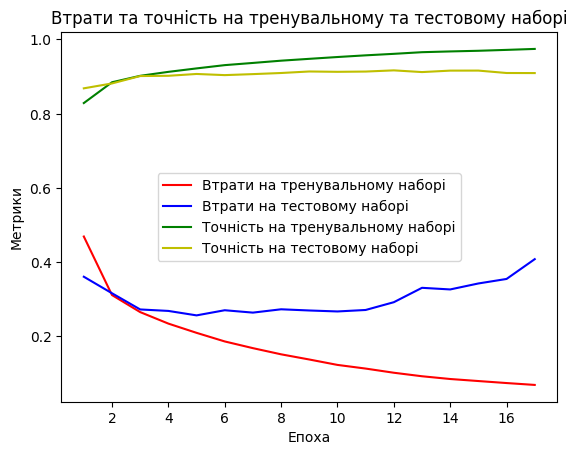

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 128, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.29202917218208313
test_acc = 0.916700005531311
train_loss = 0.07077307254076004
train_acc = 0.9745000004768372
Testing value: 256
Epoch 1/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4438 - accuracy: 0.8380 - val_loss: 0.3416 - val_accuracy: 0.8756
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2963 - accuracy: 0.8917 - val_loss: 0.2913 - val_accuracy: 0.8929
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2527 - accuracy: 0.9067 - val_loss: 0.2801 - val_accuracy: 0.8977
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2197 - accuracy: 0.9183 - val_loss: 0.2555 - val_accuracy: 0.9065
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - los

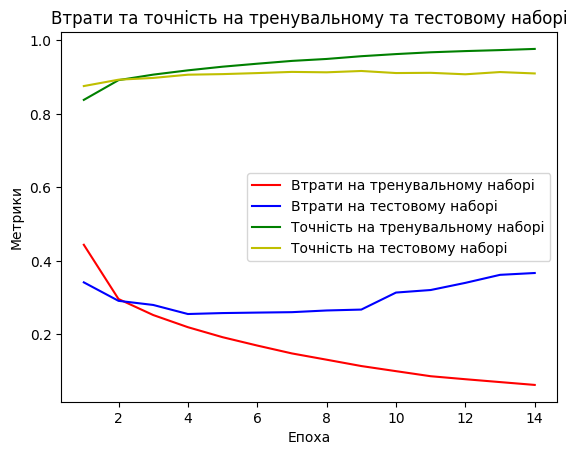

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 256, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.26757481694221497
test_acc = 0.9165999889373779
train_loss = 0.0744151771068573
train_acc = 0.9731166958808899
Testing value: 512
Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4314 - accuracy: 0.8430 - val_loss: 0.3245 - val_accuracy: 0.8819
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2864 - accuracy: 0.8941 - val_loss: 0.2948 - val_accuracy: 0.8953
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2397 - accuracy: 0.9112 - val_loss: 0.2788 - val_accuracy: 0.8980
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2072 - accuracy: 0.9230 - val_loss: 0.2641 - val_accuracy: 0.9027
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss

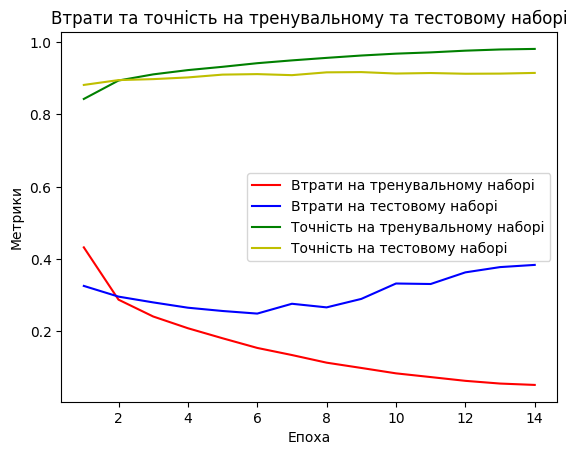

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 512, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.28849950432777405
test_acc = 0.9175000190734863
train_loss = 0.06416821479797363
train_acc = 0.9768499732017517
Optimal value for parameter hidden_units: 512, test accuracy: 0.9175000190734863

Searching for optimal value for parameter: dropout_rate
Testing value: 0.2
Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4328 - accuracy: 0.8416 - val_loss: 0.3385 - val_accuracy: 0.8763
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2919 - accuracy: 0.8918 - val_loss: 0.3062 - val_accuracy: 0.8890
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2478 - accuracy: 0.9078 - val_loss: 0.2814 - val_accuracy: 0.9005
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2

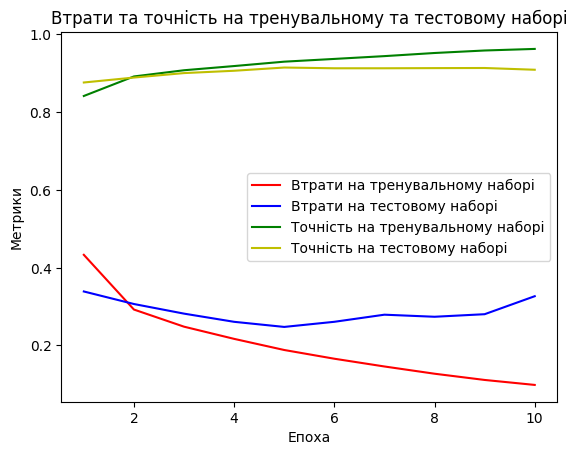

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 512, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.24720889329910278
test_acc = 0.9147999882698059
train_loss = 0.1475958377122879
train_acc = 0.9470999836921692
Testing value: 0.3
Epoch 1/20
1875/1875 [==============================] - 10s 4ms/step - loss: 0.4483 - accuracy: 0.8353 - val_loss: 0.3799 - val_accuracy: 0.8611
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2946 - accuracy: 0.8903 - val_loss: 0.3006 - val_accuracy: 0.8922
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2500 - accuracy: 0.9077 - val_loss: 0.2705 - val_accuracy: 0.9002
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2192 - accuracy: 0.9188 - val_loss: 0.2504 - val_accuracy: 0.9071
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - los

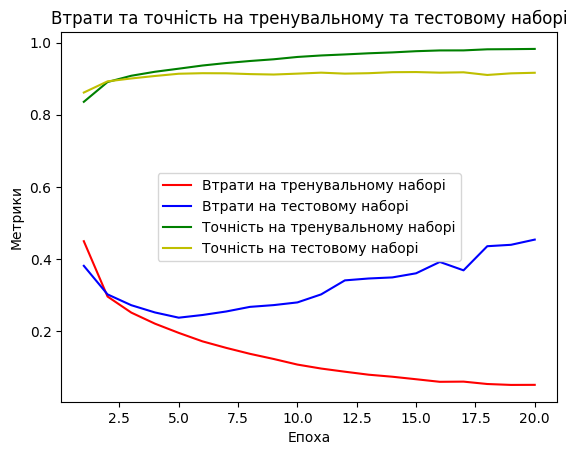

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 512, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.3591376841068268
test_acc = 0.9179999828338623
train_loss = 0.031595710664987564
train_acc = 0.9890333414077759
Testing value: 0.4
Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4577 - accuracy: 0.8333 - val_loss: 0.3344 - val_accuracy: 0.8767
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3100 - accuracy: 0.8849 - val_loss: 0.2889 - val_accuracy: 0.8946
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2661 - accuracy: 0.9013 - val_loss: 0.2749 - val_accuracy: 0.8983
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2387 - accuracy: 0.9101 - val_loss: 0.2690 - val_accuracy: 0.8995
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - los

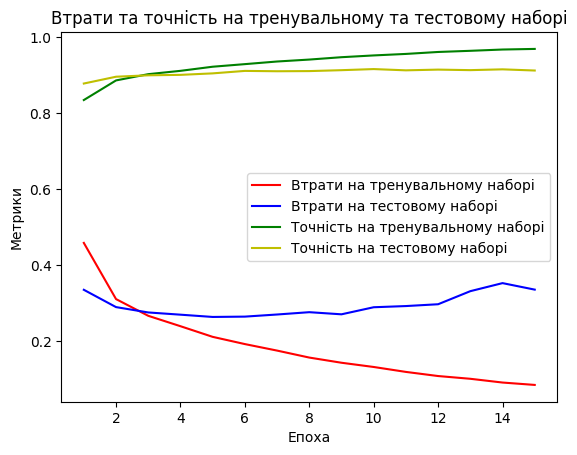

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.4, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 512, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.2885705232620239
test_acc = 0.9146999716758728
train_loss = 0.09454524517059326
train_acc = 0.9651666879653931
Optimal value for parameter dropout_rate: 0.3, test accuracy: 0.9179999828338623

Searching for optimal value for parameter: batch_size
Testing value: 32
Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4382 - accuracy: 0.8390 - val_loss: 0.3242 - val_accuracy: 0.8818
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2944 - accuracy: 0.8916 - val_loss: 0.2892 - val_accuracy: 0.8927
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2491 - accuracy: 0.9069 - val_loss: 0.2569 - val_accuracy: 0.9041
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2182 

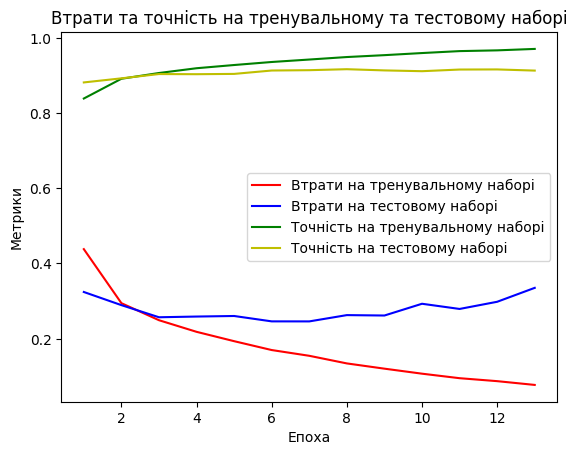

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 512, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.2626490592956543
test_acc = 0.9169999957084656
train_loss = 0.09923415631055832
train_acc = 0.9617999792098999
Testing value: 64
Epoch 1/20
938/938 [==============================] - 7s 6ms/step - loss: 0.4684 - accuracy: 0.8295 - val_loss: 0.3463 - val_accuracy: 0.8748
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.3111 - accuracy: 0.8866 - val_loss: 0.3157 - val_accuracy: 0.8857
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.2645 - accuracy: 0.9020 - val_loss: 0.2692 - val_accuracy: 0.9002
Epoch 4/20
938/938 [==============================] - 5s 5ms/step - loss: 0.2337 - accuracy: 0.9132 - val_loss: 0.2505 - val_accuracy: 0.9098
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.2095 - 

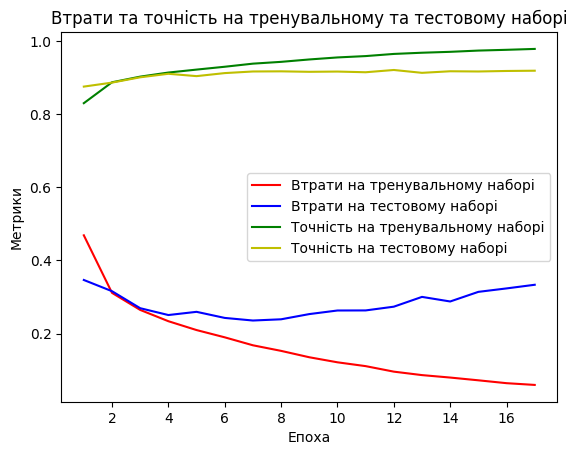

Parameters {'epochs': 20, 'batch_size': 64, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 512, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.2733815312385559
test_acc = 0.920199990272522
train_loss = 0.058938346803188324
train_acc = 0.9796500205993652
Testing value: 128
Epoch 1/20
469/469 [==============================] - 5s 6ms/step - loss: 0.5208 - accuracy: 0.8099 - val_loss: 0.3812 - val_accuracy: 0.8599
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3358 - accuracy: 0.8773 - val_loss: 0.3241 - val_accuracy: 0.8809
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2899 - accuracy: 0.8930 - val_loss: 0.3121 - val_accuracy: 0.8788
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2582 - accuracy: 0.9047 - val_loss: 0.2702 - val_accuracy: 0.9027
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2323 -

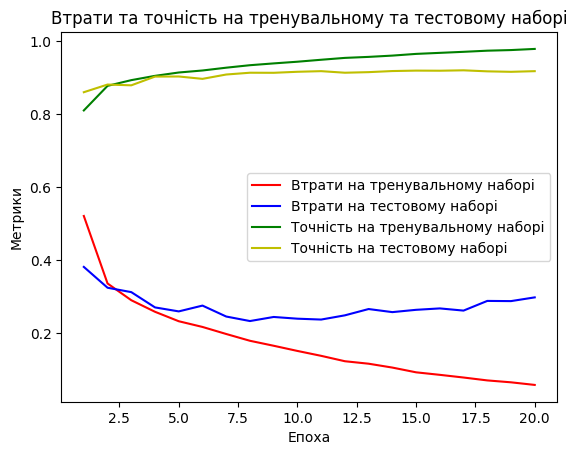

Parameters {'epochs': 20, 'batch_size': 128, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 512, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.297692209482193
test_acc = 0.9175999760627747
train_loss = 0.03600260242819786
train_acc = 0.9887166619300842
Optimal value for parameter batch_size: 64, test accuracy: 0.920199990272522

Searching for optimal value for parameter: loss_function
Testing value: sparse_categorical_crossentropy
Epoch 1/20
938/938 [==============================] - 6s 5ms/step - loss: 0.4782 - accuracy: 0.8258 - val_loss: 0.3469 - val_accuracy: 0.8766
Epoch 2/20
938/938 [==============================] - 4s 5ms/step - loss: 0.3157 - accuracy: 0.8835 - val_loss: 0.2943 - val_accuracy: 0.8938
Epoch 3/20
938/938 [==============================] - 5s 6ms/step - loss: 0.2669 - accuracy: 0.9019 - val_loss: 0.2824 - val_accuracy: 0.8953
Epoch 4/20
938/938 [==============================] - 4s 5ms/

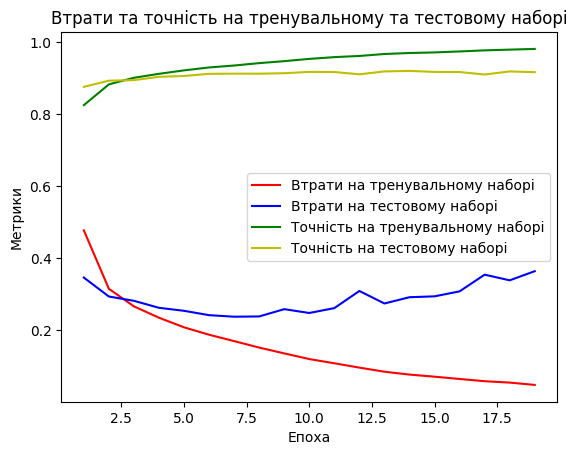

Parameters {'epochs': 20, 'batch_size': 64, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 512, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.2923542857170105
test_acc = 0.9210000038146973
train_loss = 0.0426388718187809
train_acc = 0.9856166839599609
Optimal value for parameter loss_function: sparse_categorical_crossentropy, test accuracy: 0.9210000038146973

Optimal parameters:
{'epochs': 20, 'batch_size': 64, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 512, 'activation': 'relu', 'metrics': ['accuracy']}
Test accuracy: 0.9210000038146973


In [14]:
find_optimal_1 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model)


In [15]:
optimal_parameters

{'epochs': 20,
 'batch_size': 64,
 'dropout_rate': 0.3,
 'loss_function': 'sparse_categorical_crossentropy',
 'optimizer': 'adam',
 'hidden_units': 512,
 'activation': 'relu',
 'metrics': ['accuracy']}

Optimal parameters:

{'epochs': 20,
 'batch_size': 64,
 'dropout_rate': 0.3,
 'loss_function': 'sparse_categorical_crossentropy',
 'optimizer': 'adam',
 'hidden_units': 512,
 'activation': 'relu',
 'metrics': ['accuracy']}

test_loss = 0.2923542857170105

test_acc = 0.9210000038146973

train_loss = 0.0426388718187809

train_acc = 0.9856166839599609

test accuracy: 0.9210000038146973

**test accuracy: 92.1%**


Отримані параметри навчання нейронної мережі свідчать про її успішне навчання, але може бути ознакою невеликої проблеми перенавчання.

**Точність на тестових даних (test_acc)**: Значення 0.921 вказує на те, що модель досягла точності приблизно 92.1% на данних, які вона раніше не бачила. Це відмінний показник та свідчить про те, що модель гарно узагальнює.

**Точність на тренувальних даних (train_acc)**: Значення 0.986 вказує на те, що модель майже ідеально пристосувалася до тренувальних даних, досягаючи точності близько 98.6%. Це може бути ознакою того, що **модель перенавчилася на тренувальних даних.**

**Втрати на тестових даних (test_loss)** та Втрати на тренувальних даних (train_loss): Втрати на тестових даних становлять близько 0.292, а на тренувальних - 0.043. Зазвичай ми бачимо, що втрати на тренувальних даних нижчі, ніж на тестових даних, але у даному випадку вони значно нижчі. Це може бути ознакою перенавчання моделі.

Отже, хоча модель показує високу точність на тестових даних, її точність на тренувальних даних набагато вища. Для подальшого покращення можна розглянути використання додаткових методів регуляризації, таких як **L2 регуляризація**, або **зменшення складності моделі**.

**Згідно з графіками навчання менша кількість епох навчання може бути підхожим способом для вирішення проблеми перенавчання.**

**Надалі перевірка різної кількості епох навчання:**

Searching for optimal value for parameter: epochs
Testing value: 6
Epoch 1/6
1875/1875 [==============================] - 13s 4ms/step - loss: 0.4817 - accuracy: 0.8238 - val_loss: 0.3488 - val_accuracy: 0.8728
Epoch 2/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3219 - accuracy: 0.8839 - val_loss: 0.3056 - val_accuracy: 0.8881
Epoch 3/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2770 - accuracy: 0.8973 - val_loss: 0.2836 - val_accuracy: 0.8985
Epoch 4/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2479 - accuracy: 0.9089 - val_loss: 0.2562 - val_accuracy: 0.9065
Epoch 5/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2252 - accuracy: 0.9161 - val_loss: 0.2849 - val_accuracy: 0.8993
Epoch 6/6
313/313 [==============================] - 1s 2ms/step - loss: 0.2622 - accuracy: 0.9066
Точність на тестових даних: 0.9065999984741211
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1655

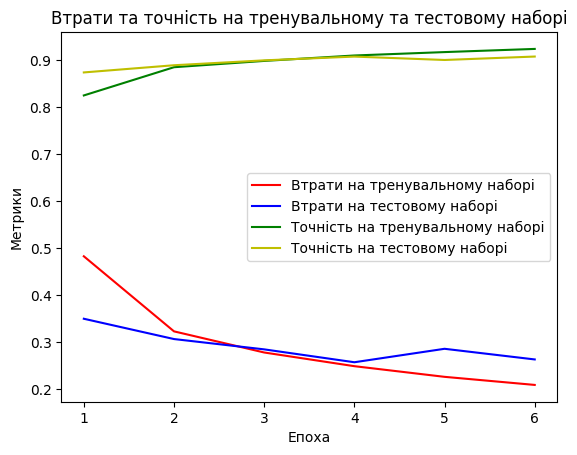

Parameters {'epochs': 6, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 64, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.2621983587741852
test_acc = 0.9065999984741211
train_loss = 0.16545291244983673
train_acc = 0.937583327293396
Testing value: 10
Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4891 - accuracy: 0.8230 - val_loss: 0.3481 - val_accuracy: 0.8744
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3252 - accuracy: 0.8814 - val_loss: 0.3045 - val_accuracy: 0.8898
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2763 - accuracy: 0.8994 - val_loss: 0.2836 - val_accuracy: 0.8979
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2466 - accuracy: 0.9088 - val_loss: 0.2621 - val_accuracy: 0.9056
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.

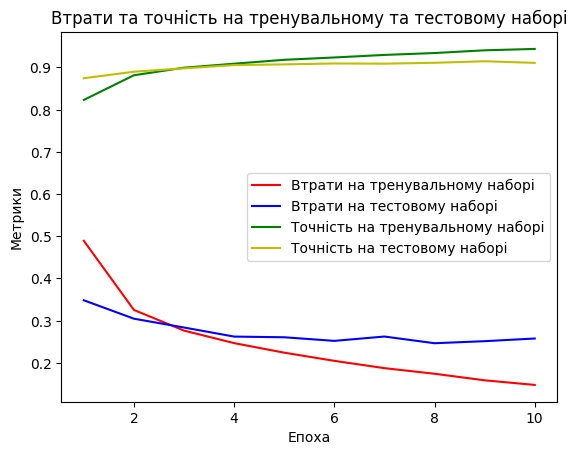

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 64, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.25752103328704834
test_acc = 0.9107999801635742
train_loss = 0.11404217034578323
train_acc = 0.9589833617210388
Testing value: 20
Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4852 - accuracy: 0.8249 - val_loss: 0.3860 - val_accuracy: 0.8553
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3236 - accuracy: 0.8821 - val_loss: 0.3032 - val_accuracy: 0.8881
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2760 - accuracy: 0.8989 - val_loss: 0.2831 - val_accuracy: 0.8987
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2470 - accuracy: 0.9091 - val_loss: 0.2749 - val_accuracy: 0.9002
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss:

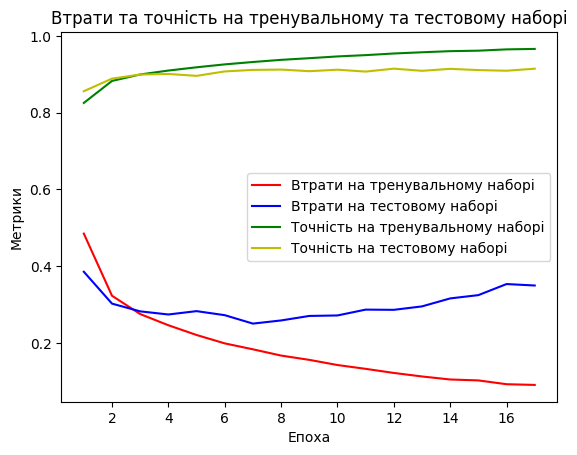

Parameters {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 64, 'activation': 'relu', 'metrics': ['accuracy']}
test_loss = 0.2870543301105499
test_acc = 0.9139999747276306
train_loss = 0.0904264822602272
train_acc = 0.9678666591644287
Optimal value for parameter epochs: 20, test accuracy: 0.9139999747276306

Optimal parameters:
{'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 64, 'activation': 'relu', 'metrics': ['accuracy']}
Test accuracy: 0.9139999747276306


In [8]:
study_sequence = [
#                  'optimizer',
#                  'activation',
#                  'hidden_units',
#                  'dropout_rate',
#                 'batch_size',
#                  'loss_function']
#                  'metrics',
                  'epochs']

optimal_parameters = {
    'epochs': 5,
    'batch_size': 32,
    'dropout_rate': 0.1,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'adam',
    'hidden_units': 64,
    'activation': 'relu',
    'metrics': ['accuracy']
    }

# Списки параметрів, що мають бути досліджені під час навчання

parameters = {
    'epochs': [6, 10, 20],
    'batch_size': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'loss_function': ['sparse_categorical_crossentropy'],
    'optimizer': ['adam', 'rmsprop'],
    'hidden_units': [128, 256, 512],
    'activation': ['relu', 'tanh'],
    'metrics': ['accuracy']
    }

find_optimal_2 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model)


**Оптимальні параметри навчання мережі**

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 64, 'activation': 'relu', 'metrics': ['accuracy']}

1. test_loss = 0.25752103328704834

2. test_acc = 0.9107999801635742

3. train_loss = 0.11404217034578323

4. train_acc = 0.9589833617210388

**МОДЕЛЬ 2**

---


**Повністю з'єднаний шар:** Кількість нейронів у повністю з'єднаних шарах зменшено до 32.

**Згортковий шар**: Доданий додатковий згортковий шар з 32 фільтрами.

**Кількість епох**: Кількість епох зменшено до 8.

**Розмір пакета**: Розмір пакета навчання зменшено до 16.

**Dropout шар**: Шар Dropout видалено.

In [10]:
def train_model2(train_images, train_labels, test_images, test_labels, epochs=20, batch_size=32, dropout_rate=0.1,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', hidden_units=32,
                activation='relu', metrics=['accuracy']):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), callbacks=[early_stopping])

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, (test_loss, test_acc), (train_loss, train_acc)

In [11]:
find_optimal_3 = train_model2(train_images, train_labels, test_images, test_labels,
            epochs=20,
            batch_size=32,
#            dropout_rate=0.1,
            loss_function='sparse_categorical_crossentropy',
            optimizer='adam',
            hidden_units=32,
            activation='relu',
            metrics=['accuracy'])

Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.5208 - accuracy: 0.8122 - val_loss: 0.3944 - val_accuracy: 0.8612
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3555 - accuracy: 0.8711 - val_loss: 0.3765 - val_accuracy: 0.8640
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3089 - accuracy: 0.8885 - val_loss: 0.3246 - val_accuracy: 0.8839
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2769 - accuracy: 0.8999 - val_loss: 0.3151 - val_accuracy: 0.8894
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2562 - accuracy: 0.9067 - val_loss: 0.2843 - val_accuracy: 0.8965
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2388 - accuracy: 0.9122 - val_loss: 0.2791 - val_accuracy: 0.9004
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2237 - accuracy: 0.9183 - val_loss: 0.2675 - val_accuracy:

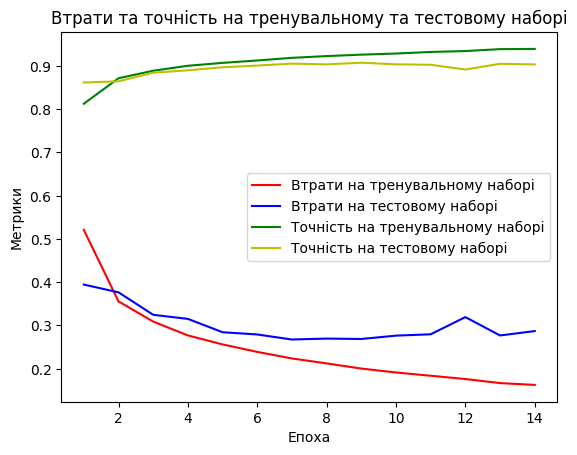

In [13]:
plot_history(find_optimal_3[1])

**Спрощення моделі трохи знизило загальну точність, проте в межах прийнятного**

**Результати навчання згорткової мережі значно кращі за результати навчання звичайної нейронної мережі навіть за набагато меншої кількості кроків навчання (5 кроків навчання CNN дозволяють досягти значно кращих результатів ніж 20-50 кроків навчання звичайної нейронної мережі).**